#### Setup for Google Colab (Optional)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### UPDATE IT IF NEEDED

In [2]:
cd 'drive/MyDrive/Colab Notebooks/comparative-study-bgru-gan-model'

/content/drive/MyDrive/Colab Notebooks/comparative-study-bgru-gan-model


In [3]:
ls

'0. Stock filtering.ipynb'           diagrams/
'1. Data fetching.ipynb'             model/
'2. Data Processing.ipynb'          'Personal notes.md'
'3.1. Model Training - BGRU.ipynb'   README.md
'3.2. Model Training - GAN.ipynb'    requirements.txt
'4. Model Evaluation.ipynb'          scaler/
 data/


# Model Training
Train BGRU models for HK and US stock market, repectively

In [239]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.metrics import Accuracy, MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError, MeanSquaredError
from keras.callbacks import ModelCheckpoint, EarlyStopping

### Common variables and functions

In [240]:
MODEL_STRUCTURE_PATH = "./diagrams/model/structures"
MODEL_TRAIN_HISTORY_DIAGRAMS_PATH = "./diagrams/model/training"
# PROCESSED_STOCKS_PATH = "./data/processed"
TRAINING_STOCKS_PATH = "./data/processed/training_data"
EVALUATE_STOCKS_PATH = "./data/processed/stocks_for_evaluate"
TRAIN_STOCK_NAMES_PATH = "./data/processed/stock_names_for_training"

# stocks model checkpoint paths
HK_MODELS_CHECKPOINT_PATH = "./model/hk"
US_MODELS_CHECKPOINT_PATH = "./model/us"

hk_bgru_file_path = "{}/bgru.h5".format(HK_MODELS_CHECKPOINT_PATH)
hk_bgru_train_history_file_path = "{}/bgru_training_history.npy".format(HK_MODELS_CHECKPOINT_PATH)

us_bgru_file_path = "{}/bgru.h5".format(US_MODELS_CHECKPOINT_PATH)
us_bgru_train_history_file_path = "{}/bgru_training_history.npy".format(US_MODELS_CHECKPOINT_PATH)

TRAIN_EPOCHS = 100

def create_dir_if_not_exist(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname, exist_ok=True)

### Import datasets

In [241]:
# stock names
template_filename_train_x = "{}/{}_train_X.npy"
template_filename_train_y = "{}/{}_train_y.npy"

template_filename_test_x = "{}/{}_test_X.npy"
template_filename_test_y = "{}/{}_test_y.npy"

fns_hk = np.load("{}/hk_train_stock_names.npy".format(TRAIN_STOCK_NAMES_PATH))
fns_us = np.load("{}/us_train_stock_names.npy".format(TRAIN_STOCK_NAMES_PATH))

X_train_hk = {}
y_train_hk = {}
X_test_hk = {}
y_test_hk = {}
for i in range(len(fns_hk)):
    X_train_hk[fns_hk[i]] = np.load(template_filename_train_x.format(
        TRAINING_STOCKS_PATH,
        fns_hk[i]
    ))

    y_train_hk[fns_hk[i]] = np.load(template_filename_train_y.format(
        TRAINING_STOCKS_PATH,
        fns_hk[i]
    ))

    X_test_hk[fns_hk[i]] = np.load(template_filename_test_x.format(
        TRAINING_STOCKS_PATH,
        fns_hk[i]
    ))

    y_test_hk[fns_hk[i]] = np.load(template_filename_test_y.format(
        TRAINING_STOCKS_PATH,
        fns_hk[i]
    ))

X_train_us = {}
y_train_us = {}
X_test_us = {}
y_test_us = {}
for i in range(len(fns_us)):
    X_train_us[fns_us[i]] = np.load(template_filename_train_x.format(
        TRAINING_STOCKS_PATH,
        fns_us[i]
    ))

    y_train_us[fns_us[i]] = np.load(template_filename_train_y.format(
        TRAINING_STOCKS_PATH,
        fns_us[i]
    ))

    X_test_us[fns_us[i]] = np.load(template_filename_test_x.format(
        TRAINING_STOCKS_PATH,
        fns_us[i]
    ))

    y_test_us[fns_us[i]] = np.load(template_filename_test_y.format(
        TRAINING_STOCKS_PATH,
        fns_us[i]
    ))

# Check the imports, minus the one stock that used to test generalizability
assert len(X_train_hk) == 49
assert len(y_train_hk) == 49
assert len(X_test_hk) == 49
assert len(X_test_hk) == 49

assert len(X_train_us) == 49
assert len(y_train_us) == 49
assert len(X_test_us) == 49
assert len(X_test_us) == 49

# # hk datasets
# X_train_hk = np.load("{}/train_X_hk.npy".format(PROCESSED_STOCKS_PATH))
# X_test_hk = np.load("{}/test_X_hk.npy".format(PROCESSED_STOCKS_PATH))
# y_train_hk = np.load("{}/train_y_hk.npy".format(PROCESSED_STOCKS_PATH))
# y_test_hk = np.load("{}/test_y_hk.npy".format(PROCESSED_STOCKS_PATH))
#
# # us datasets
# X_train_us = np.load("{}/train_X_us.npy".format(PROCESSED_STOCKS_PATH))
# X_test_us = np.load("{}/test_X_us.npy".format(PROCESSED_STOCKS_PATH))
# y_train_us = np.load("{}/train_y_us.npy".format(PROCESSED_STOCKS_PATH))
# y_test_us = np.load("{}/test_y_us.npy".format(PROCESSED_STOCKS_PATH))

### Define models structure
##### BGRU models
###### Reference:
```
Salimath, S., Chatterjee, T., Mathai, T., Kamble, P., & Kolhekar, M. (2021, April). Prediction of Stock Price for Indian Stock Market: A Comparative Study Using LSTM and GRU. In International Conference on Advances in Computing and Data Sciences (pp. 292-302). Springer, Cham.
Lin, H., Chen, C., Huang, G., & Jafari, A. (2021). Stock price prediction using Generative Adversarial Networks. Journal of Computer Science, (17(3), 188–196. doi:10.3844/jcssp.2021.188.196
https://github.com/grudloff/stock_market_GAN
Train with multiple stocks: https://www.kaggle.com/humamfauzi/multiple-stock-prediction-using-single-nn
```

In [242]:
def make_bgru_model(input_dim, feature_cnt) -> tf.keras.models.Model:
    model = Sequential()

    # input layer
    model.add(
        Input(
            shape=(input_dim, feature_cnt)
        )
    )

    # first gru + dropout layer
    model.add(
        # Bidirectional(
            GRU(
                units=50,
                return_sequences=True,
                input_shape=(input_dim, feature_cnt),
                activation="tanh"
                )
        # )
    )
    model.add(
        Dropout(rate=0.3)
    )

    # second gru + dropout layer
    model.add(
        # Bidirectional(
            GRU(
                units=50,
                return_sequences=False, # important, convert array from 3d to 2d
                input_shape=(input_dim, feature_cnt),
                activation="tanh"
                )
        # )
    )
    model.add(
        Dropout(rate=0.5)
    )

    # output dense layer
    model.add(
        Dense(units = 1)
    )

    # compile model and use Adam optimizer
    model.compile(
        # optimizer=Adam(learning_rate=0.001),
        optimizer=Adam(learning_rate=0.0001),
        loss="mean_squared_error",
        metrics=[
            MeanAbsoluteError(),
            RootMeanSquaredError(),
            MeanAbsolutePercentageError()
        ]
    )

    print(model.summary())
    return model

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_109 (GRU)                (None, 30, 50)            9150      
_________________________________________________________________
dropout_112 (Dropout)        (None, 30, 50)            0         
_________________________________________________________________
gru_110 (GRU)                (None, 50)                15300     
_________________________________________________________________
dropout_113 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 51        
Total params: 24,501
Trainable params: 24,501
Non-trainable params: 0
_________________________________________________________________
None


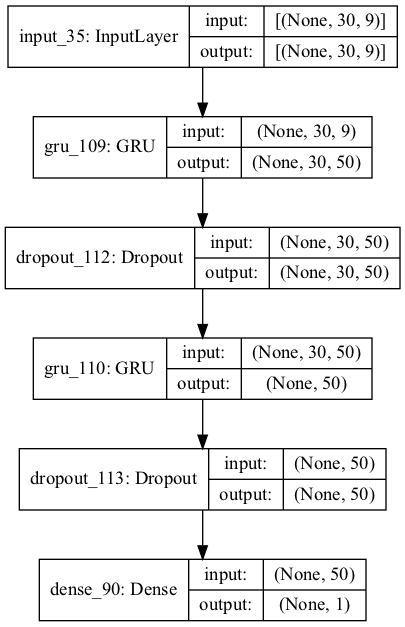

In [243]:
# plot model structure
create_dir_if_not_exist(MODEL_STRUCTURE_PATH)
plot_model(
    make_bgru_model(input_dim=X_train_hk[fns_hk[0]].shape[1],
                    feature_cnt=X_train_hk[fns_hk[0]].shape[2]
                    ),
    show_shapes=True,
    show_layer_names=True,
    to_file="{}/BGRU_structure.png".format(MODEL_STRUCTURE_PATH)
)


### Model training
##### Train BGRU model for Hong Kong Stocks

In [9]:
create_dir_if_not_exist(HK_MODELS_CHECKPOINT_PATH)
create_dir_if_not_exist(US_MODELS_CHECKPOINT_PATH)

In [12]:
hk_bgru_cp = ModelCheckpoint(
    filepath=hk_bgru_file_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
    mode="min"
)

hk_bgru_es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10
)

hk_bgru_model = None
# check if we have previously trained model or not, ref: https://stackoverflow.com/a/56425146/9500852
if os.path.exists(hk_bgru_file_path):
    print("Found existing model")
    hk_bgru_model = load_model(hk_bgru_file_path)
    # score = hk_bgru_model.evaluate()
else:
    print("No existing model is found")
    hk_bgru_model = make_bgru_model(
        input_dim=X_train_hk[fns_hk[0]].shape[1],
        feature_cnt=X_train_hk[fns_hk[0]].shape[2]
    )

# start fitting the model
hk_bgru_history = None

for i in range(len(fns_hk)):
    print("\n--- Training {}, {} stocks remains ---".format(fns_hk[i], len(fns_hk) - i))
    hk_bgru_history = hk_bgru_model.fit(
        x=X_train_hk[fns_hk[i]],
        y=y_train_hk[fns_hk[i]],
        validation_data=(X_test_hk[fns_hk[i]], y_test_hk[fns_hk[i]]),
        epochs=TRAIN_EPOCHS,
        callbacks=[
            hk_bgru_cp,
            hk_bgru_es
        ]
    )

    hk_bgru_model.save(hk_bgru_file_path)
    print("After trained {}, Model Saved".format(fns_hk[i]))

# hk_bgru_history = hk_bgru_model.fit(
#     x=X_train_hk,
#     y=y_train_hk,
#     validation_data=(X_test_hk, y_test_hk),
#     epochs=TRAIN_EPOCHS,
#     callbacks=[
#         hk_bgru_cp,
#         hk_bgru_es
#     ]
# )

# save the model
if hk_bgru_model is not None:
    hk_bgru_model.save(hk_bgru_file_path)
    print("Model Saved")

# save the training history
if hk_bgru_history is not None:
    np.save(hk_bgru_train_history_file_path, hk_bgru_history.history)
    print("History Saved")

No existing model is found
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 30, 100)          18300     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 30, 100)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 100)              45600     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 64,001
Traina

# Test train for one stock only

In [246]:
hk_bgru_cp = ModelCheckpoint(
    filepath=hk_bgru_file_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
    mode="min"
)

hk_bgru_es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10
)

hk_bgru_model = None
# check if we have previously trained model or not, ref: https://stackoverflow.com/a/56425146/9500852
if os.path.exists(hk_bgru_file_path):
    print("Found existing model")
    hk_bgru_model = load_model(hk_bgru_file_path)
    # score = hk_bgru_model.evaluate()
else:
    print("No existing model is found")
    hk_bgru_model = make_bgru_model(
        input_dim=X_train_hk[fns_hk[0]].shape[1],
        feature_cnt=X_train_hk[fns_hk[0]].shape[2]
    )

# from tensorflow.keras.layers import LSTM
# hk_bgru_model = Sequential()
# hk_bgru_model.add(Bidirectional(LSTM(units= 128), input_shape=(X_train_hk[fns_hk[0]].shape[1], X_train_hk[fns_hk[0]].shape[2])))
# hk_bgru_model.add(Dense(64))
# hk_bgru_model.add(Dense(units=1))
#
# hk_bgru_model.compile(optimizer=Adam(lr = 0.001), loss='mean_squared_error',
#                   metrics=[
#                     # MeanAbsoluteError(),
#                     # RootMeanSquaredError(),
#                     # MeanAbsolutePercentageError()
#                 ])

# print(hk_bgru_model.summary())

print("\n--- Training {}, {} stocks remains ---".format("1038.HK", 0))
hk_bgru_history = hk_bgru_model.fit(
    x=X_train_hk["1038.HK"],
    y=y_train_hk["1038.HK"],
    validation_data=(X_test_hk["1038.HK"], y_test_hk["1038.HK"]),
    epochs=TRAIN_EPOCHS,
    # batch_size=32,
    callbacks=[
        hk_bgru_cp,
        hk_bgru_es
    ],
    shuffle=False
)

hk_bgru_model.save(hk_bgru_file_path)
print("After trained {}, Model Saved".format("1038.HK"))
np.save(hk_bgru_train_history_file_path, hk_bgru_history.history)
print("History Saved")

No existing model is found
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_111 (GRU)                (None, 30, 50)            9150      
_________________________________________________________________
dropout_114 (Dropout)        (None, 30, 50)            0         
_________________________________________________________________
gru_112 (GRU)                (None, 50)                15300     
_________________________________________________________________
dropout_115 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 51        
Total params: 24,501
Trainable params: 24,501
Non-trainable params: 0
_________________________________________________________________
None

--- Training 1038.HK, 0 stocks remains ---
Epoch 1/100
61/61 [====================

In [237]:
X_train_hk[fns_hk[0]].shape

(1947, 30, 9)

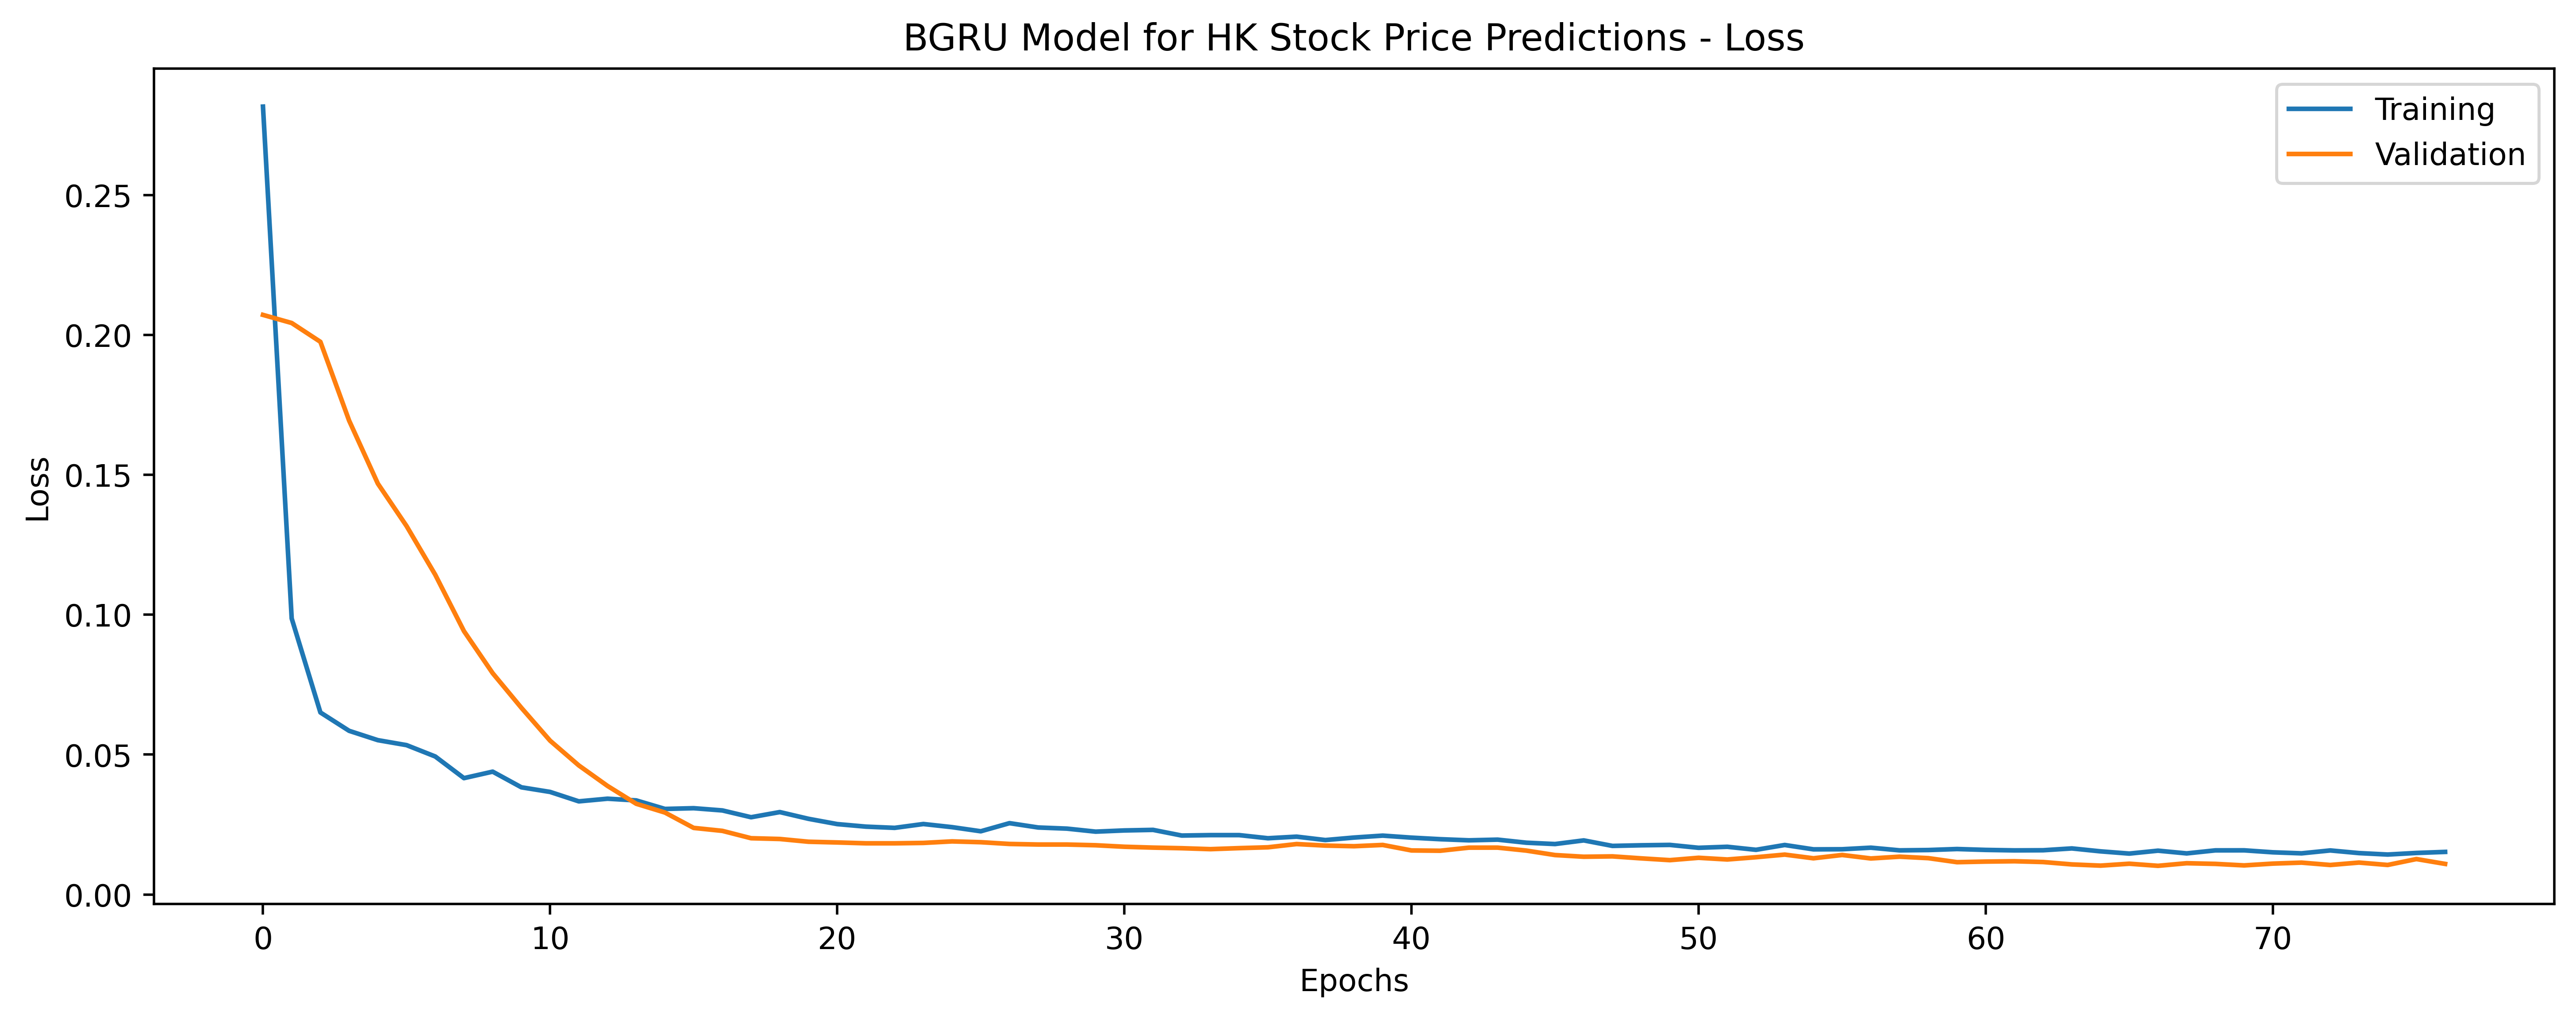

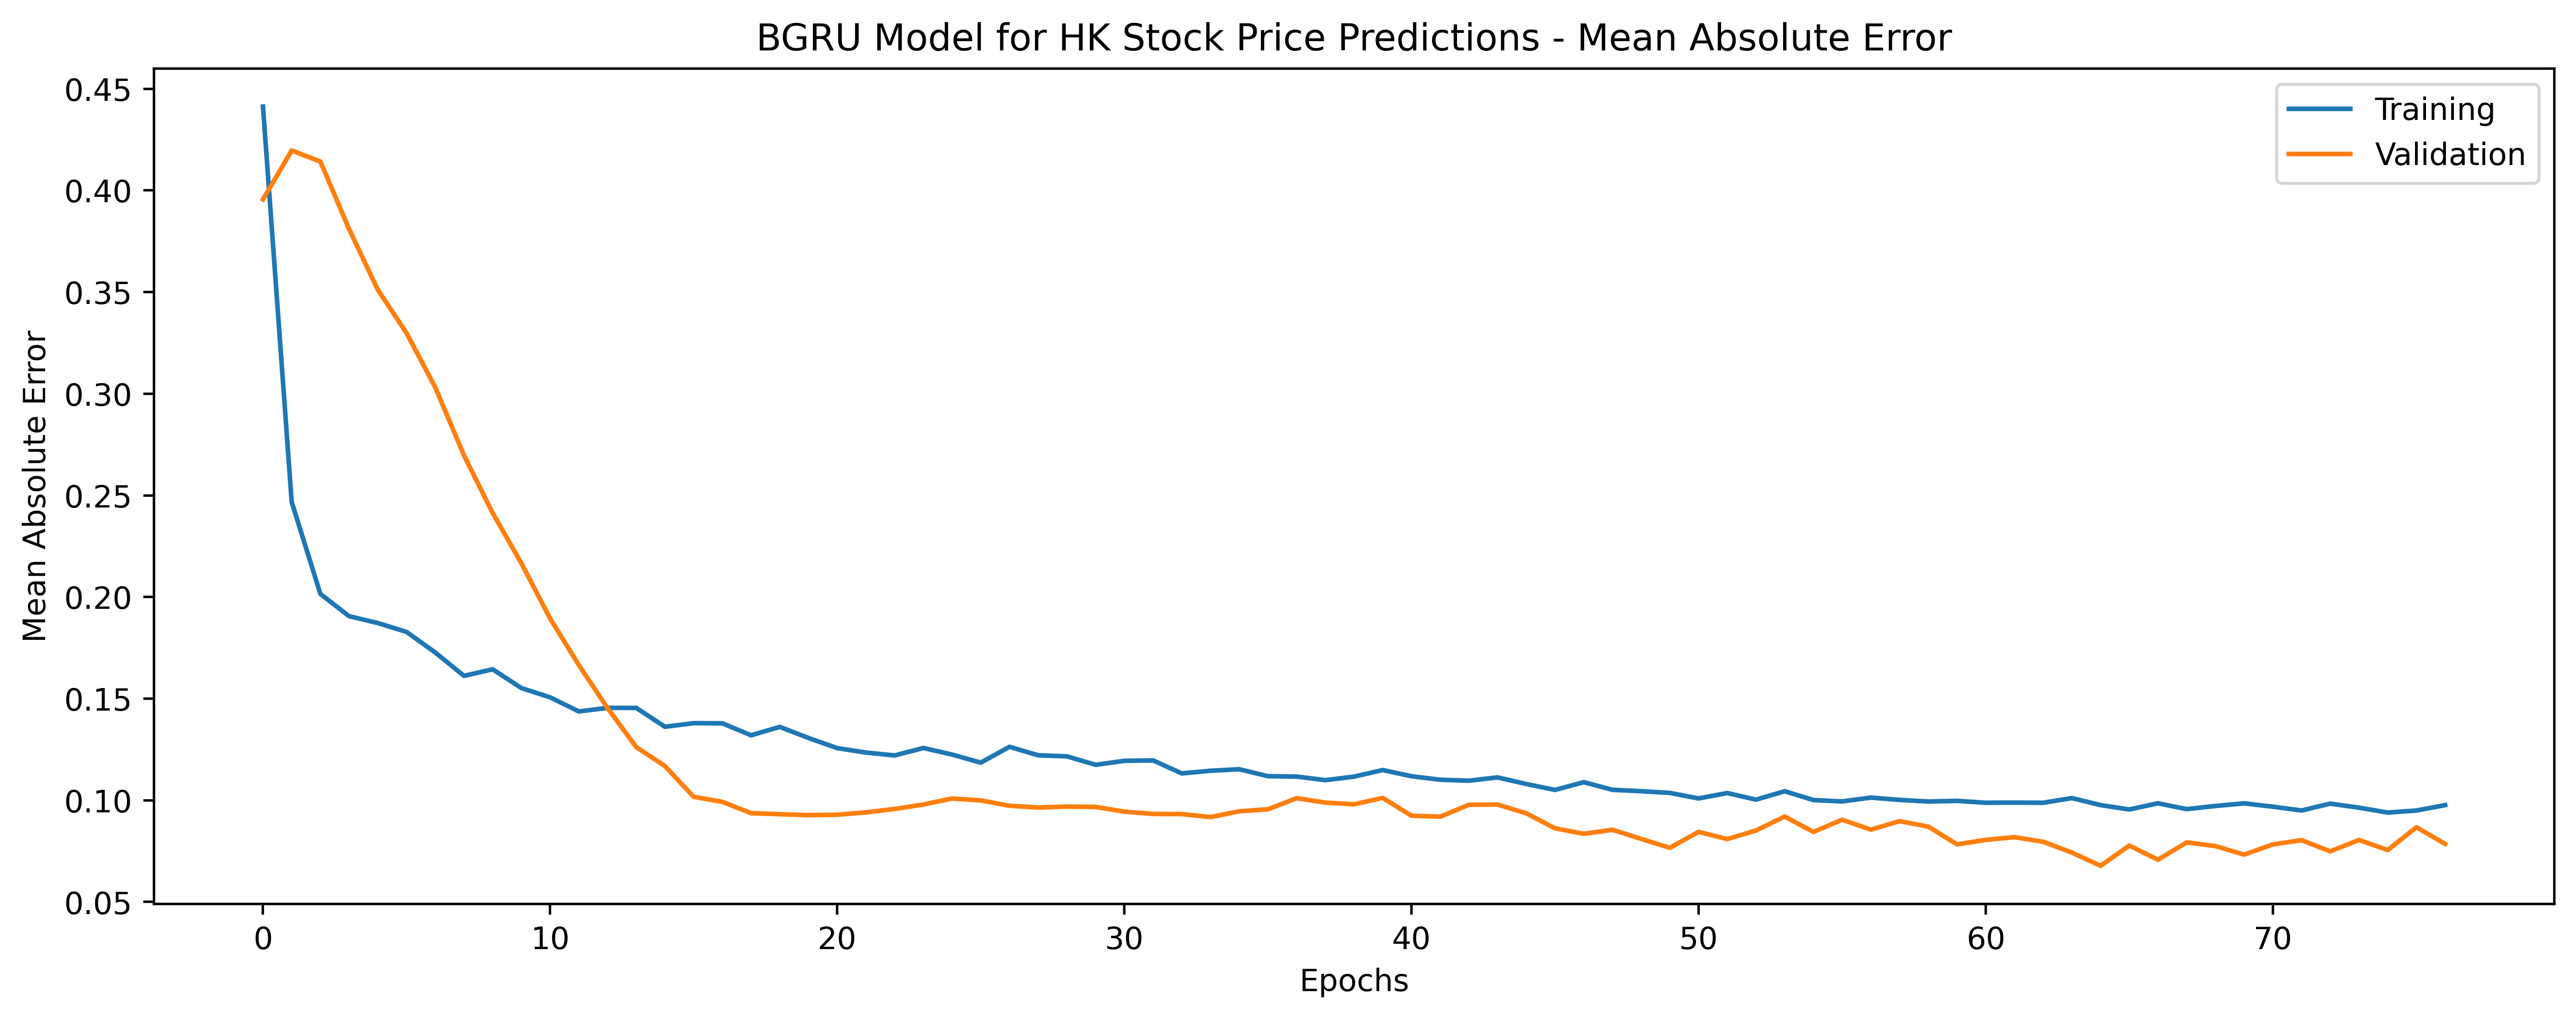

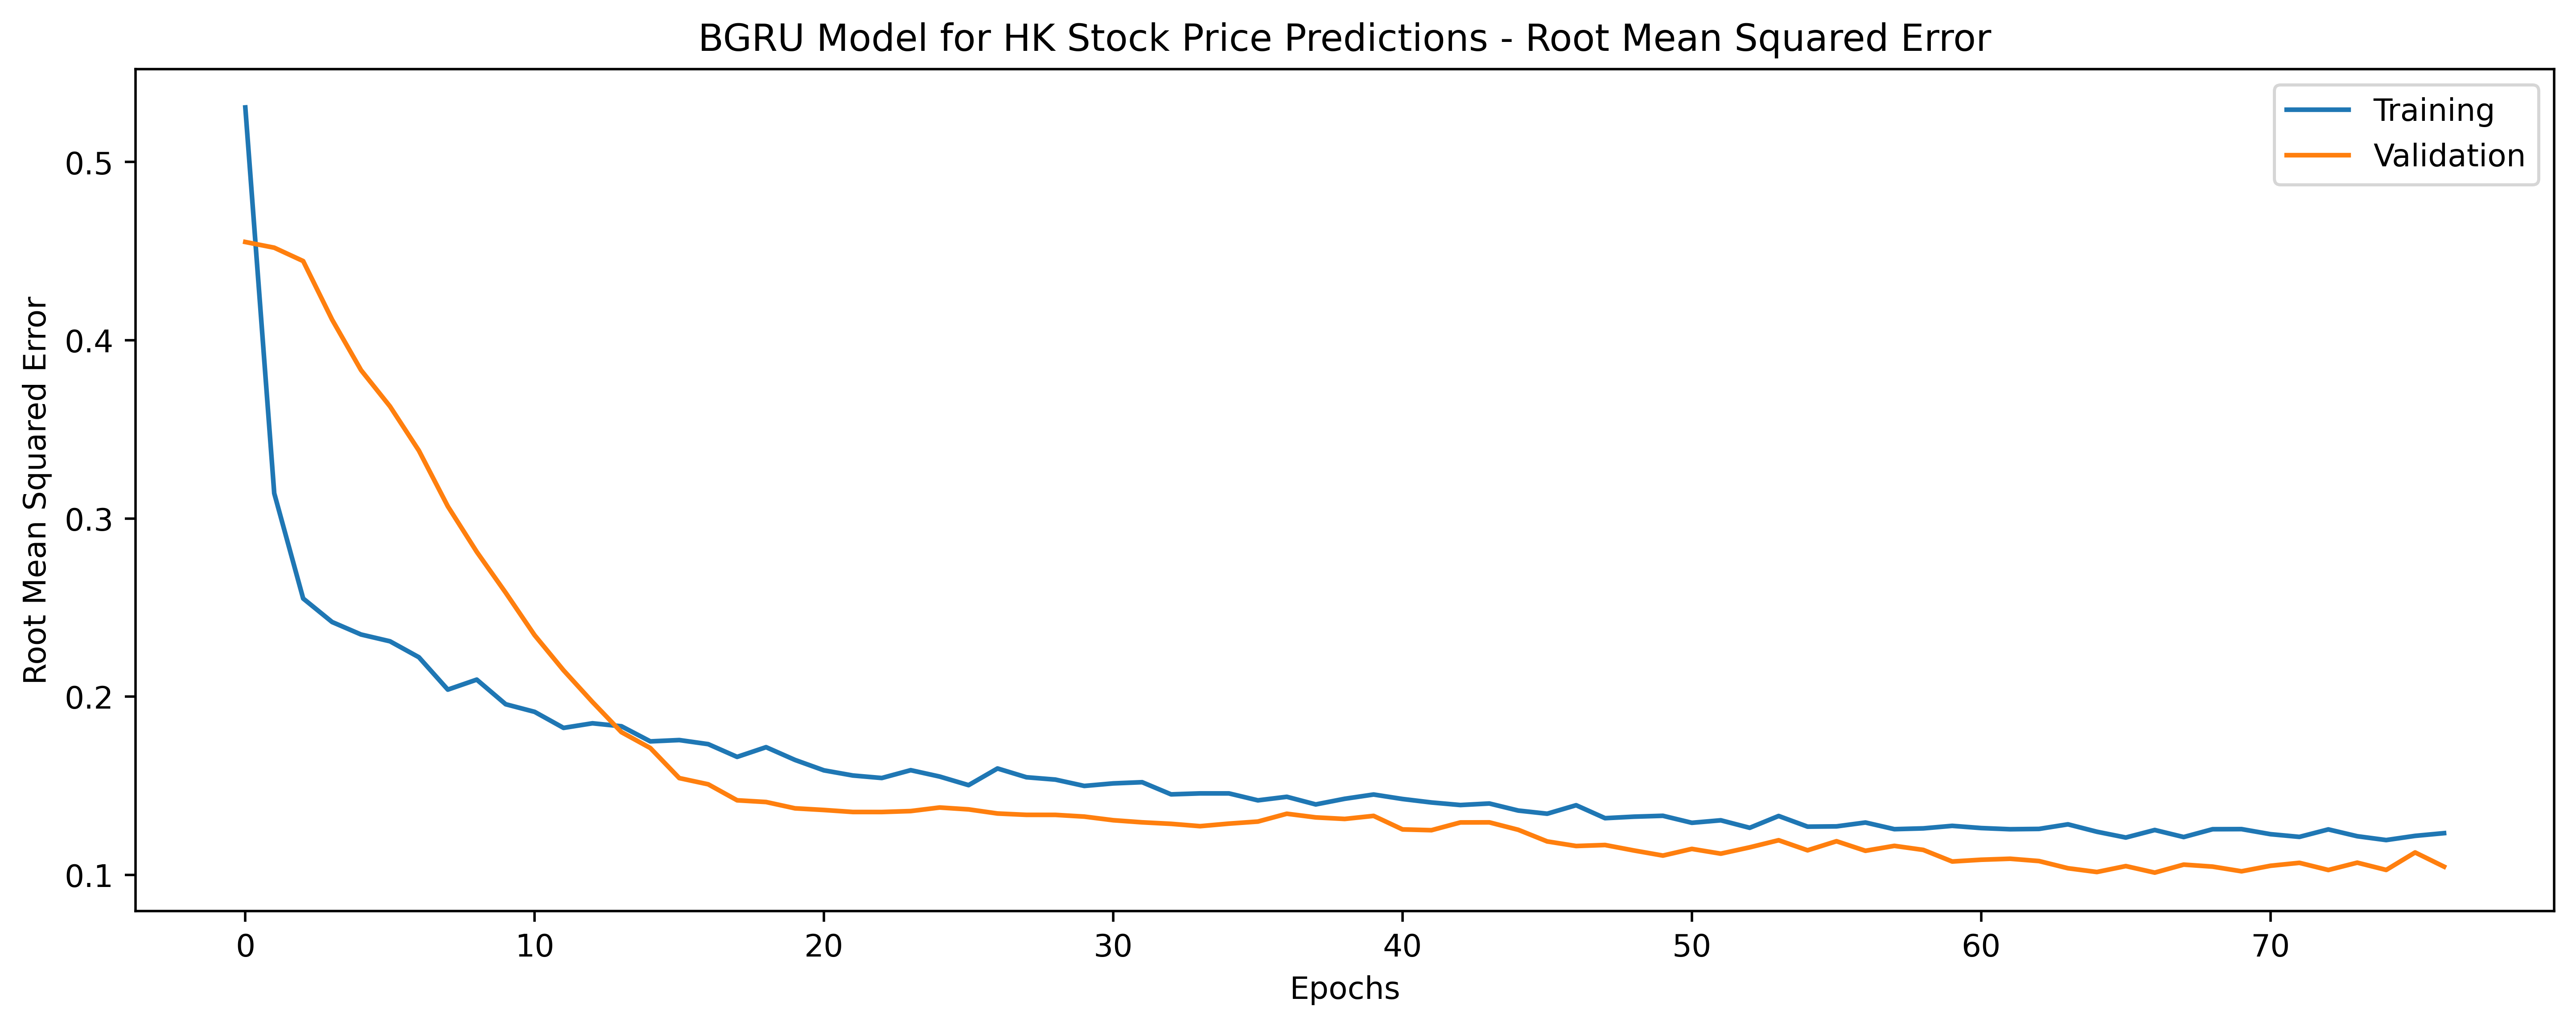

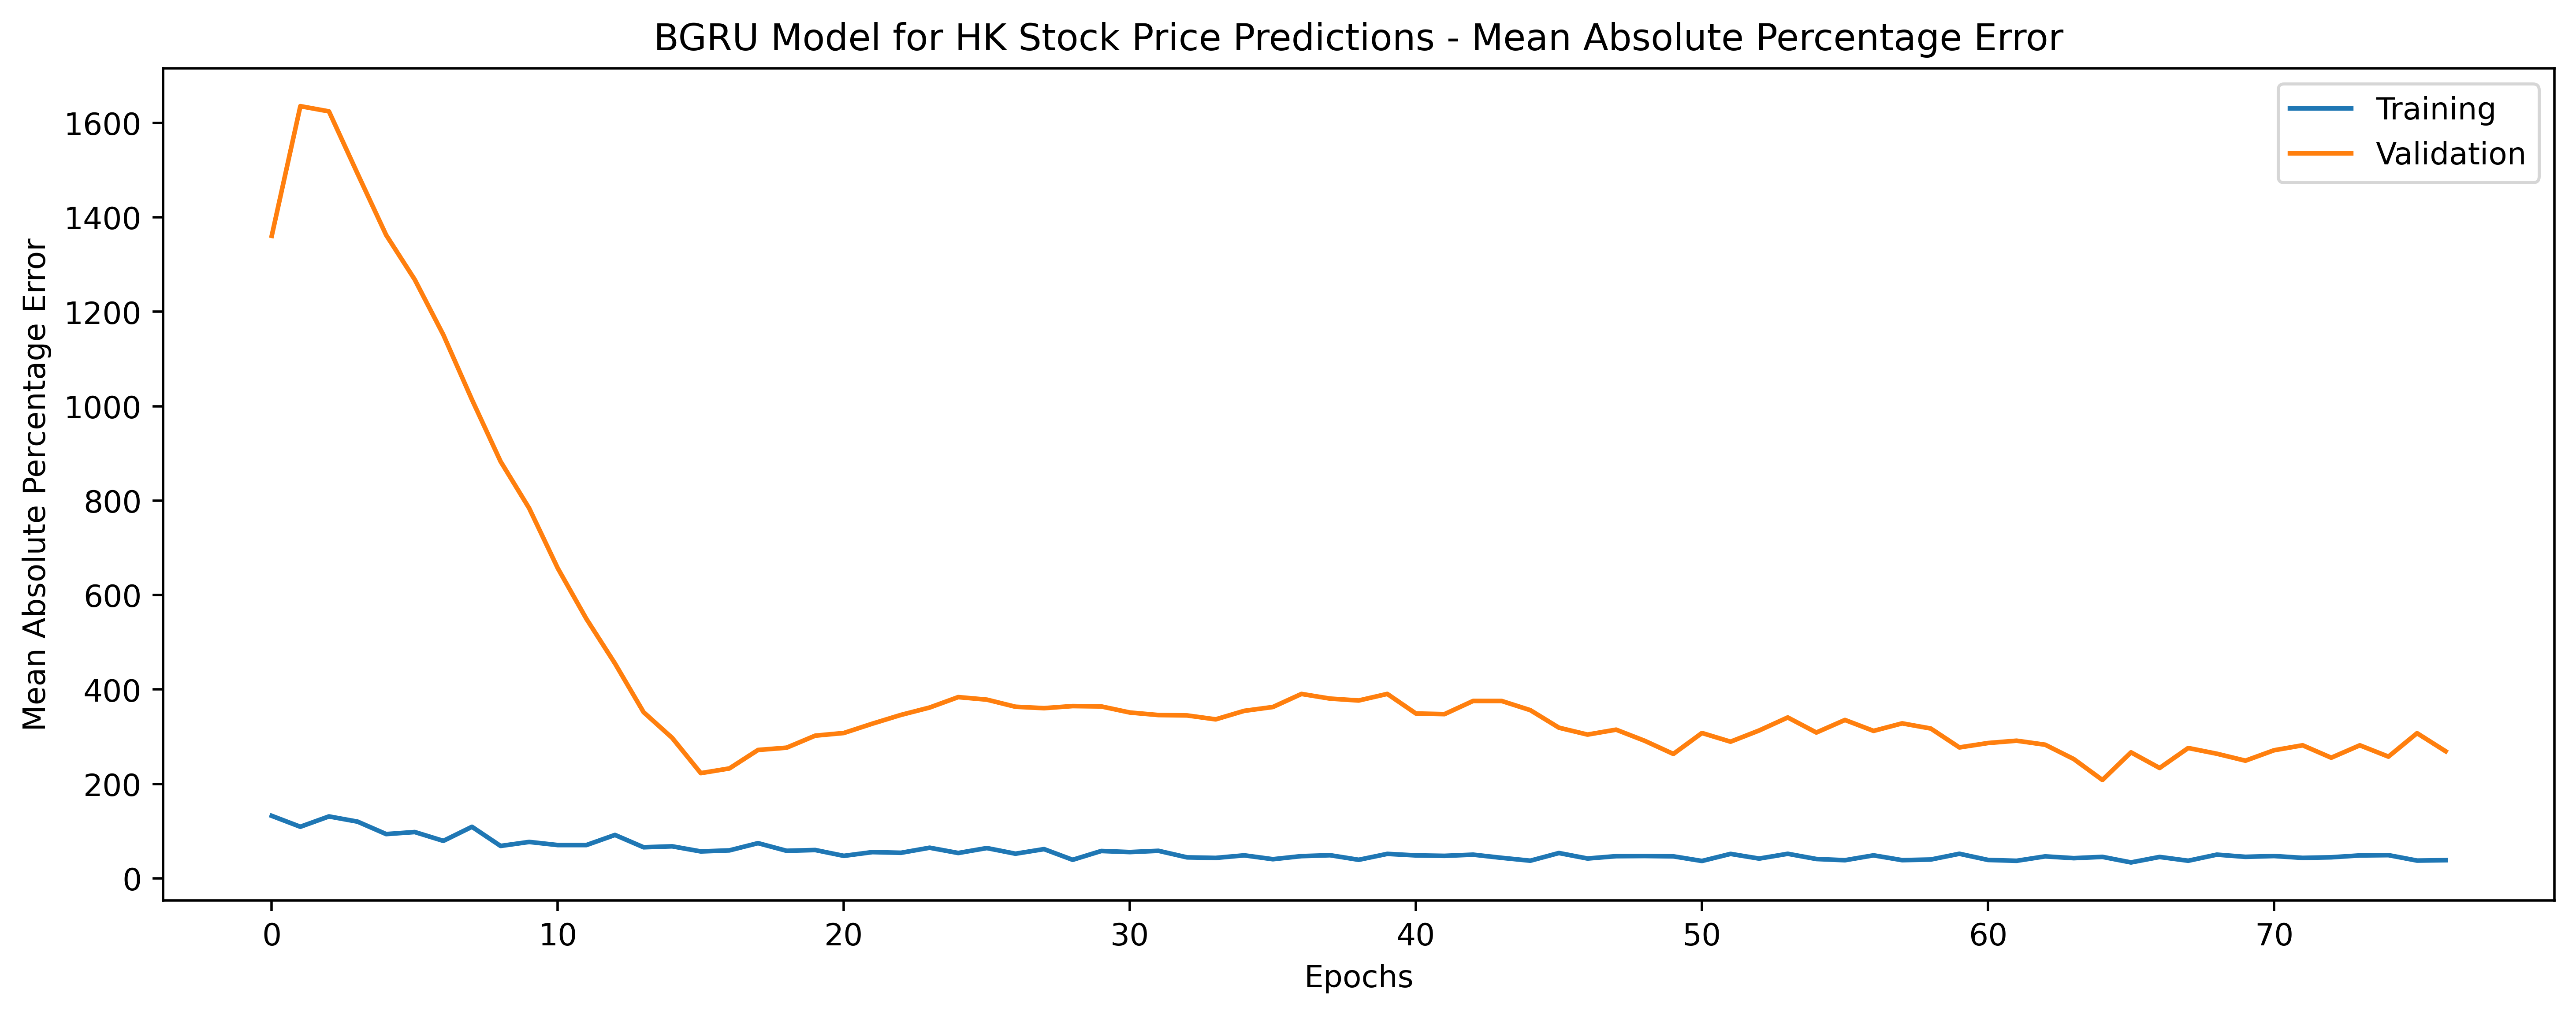

In [247]:
# plot training history
def plot_history(history_dict, title):
    """
    Plot the training history
    :param history_dict: dict, the training history, should be a dict (from keras' history.history)
    :param title: str, plot title, example: "HK BGRU Model - {}", the program will replace the {} with the relevant metric name
    :return:
    """
    metrics = ["loss",
           "mean_absolute_error",
           "root_mean_squared_error",
           "mean_absolute_percentage_error"
           # "val_loss",
           # "val_mean_absolute_error",
           # "val_root_mean_squared_error",
           # "val_mean_absolute_percentage_error"
           ]

    for metric in metrics:
        plt.figure(figsize=(14, 5), dpi=500, facecolor="white")
        # metrics.replace("_", "").title()
        plt.plot(history_dict[metric], label="Training")
        plt.plot(history_dict["val_{}".format(metric)], label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(title.format(metric.replace("_", " ").title()))
        plt.legend()
        create_dir_if_not_exist(MODEL_TRAIN_HISTORY_DIAGRAMS_PATH)
        # plt.savefig('{}/{}.png'.format(MODEL_TRAIN_HISTORY_DIAGRAMS_PATH, plt.gca().get_title()))
        plt.show()

hk_gru_history_dict = np.load(hk_bgru_train_history_file_path, allow_pickle=True).item()
plot_history(hk_gru_history_dict, "BGRU Model for HK Stock Price Predictions - {}")


##### Train BGRU model for United States stocks
